Business Goal 4: We will predict when Glossier demand will be highest over the next year and contrast that with competitor forecasts.

Technical Proposal: Leveraging regular expressions and searching techniques, we will identify the number of posts and comments that Glossier is mentioned in by day.  Using the total activity by day as demand, we will perform exploratory data analysis to identify if seasonality is present and what type of ML model should be leveraged (e.g., ARMA, SARIMA, etc.) for univariate time series forecasting. This information will be depicted on line charts to easily see demand fluctuations, seasonality, and forecasts over time. The output of this analysis will give us insight into how Glossier should manage their inventory. This same analysis will be repeated for Ulta Beauty (competitor) to have a benchmark for comparison.

Glossier Activity

In [0]:
# loading in the data
import pandas as pd
join_df = pd.read_csv('/Workspace/Repos/cag199@georgetown.edu/fall-2022-reddit-big-data-project-project-group-16/data/csv/EDA/viz_2.csv')
join_df.head()

,Unnamed: 0,dt_day,total_activity
0,0,2021-01-01,181.0
1,1,2021-01-02,207.0
2,2,2021-01-03,188.0
3,3,2021-01-04,276.0
4,4,2021-01-05,302.0


In [0]:
# creating bool series True for NaN values
bool_series = pd.isnull(join_df["total_activity"])
   
# filtering data
join_df[bool_series]

,Unnamed: 0,dt_day,total_activity
469,469,2022-04-15,NaN


In [0]:
# let's imput this as the average of the days near it
row_index_list = [467, 468, 470, 471]

imp_mean = join_df["total_activity"].iloc[row_index_list].mean(axis=0)
imp_mean

Out[28]: 97.75

In [0]:
# imputing nulls as zeros
join_df["total_activity"] = join_df["total_activity"].fillna(imp_mean)
join_df["total_activity"].isnull().sum()

Out[29]: 0

In [0]:
# resource: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

# Drop first column of dataframe
join_df = join_df.iloc[: , 1:]

# datatype parsing
join_df["dt_day"] = pd.to_datetime(join_df["dt_day"], format="%Y-%m-%d")
join_df = join_df.set_index('dt_day')
join_df.head()

,total_activity
dt_day,
2021-01-01,181.0
2021-01-02,207.0
2021-01-03,188.0
2021-01-04,276.0
2021-01-05,302.0


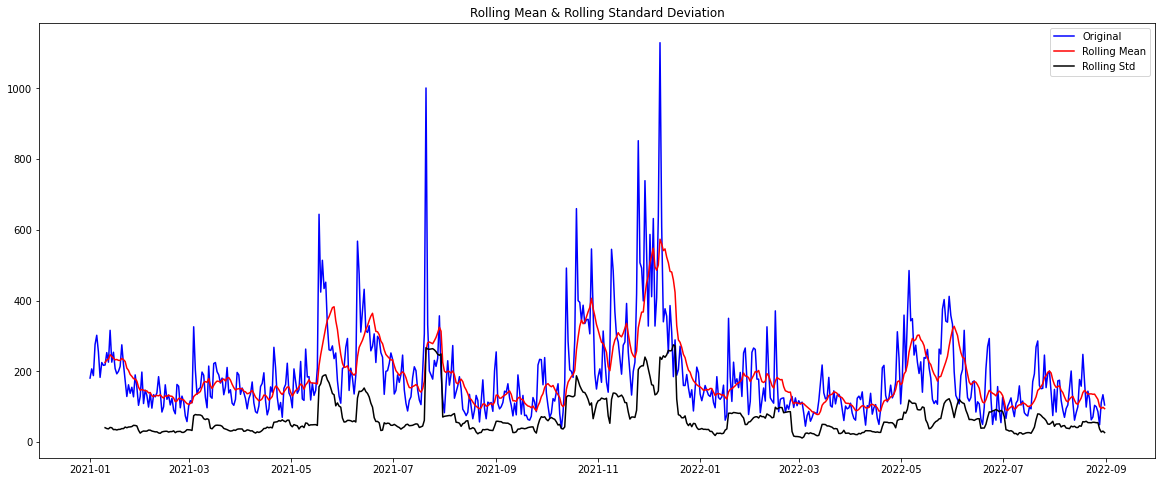

In [0]:
# viewing the rolling mean and rolling std
# resource: https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7
import matplotlib.pyplot as plt

rolling_mean = join_df.rolling(window = 10).mean()
rolling_std = join_df.rolling(window = 10).std()

plt.figure(figsize=(20,8))
plt.plot(join_df, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

One can see that the rolling mean and std do not really increase over time so the series is relatively stationary.

In [0]:
# let's check the Augmented Dickey-Fuller Test to be sure
from statsmodels.tsa.stattools import adfuller

result = adfuller(join_df['total_activity'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))

ADF Statistic: -3.5321078567243536
p-value: 0.007199784838828599


Here, one can see that the p value is lower than 0.05 so we can conclude that the series is stationary, meaning not increasing or decreasing steadily over time.

In [0]:
# converting to series
series = join_df.squeeze()
series.head()

Out[33]: dt_day
2021-01-01    181.0
2021-01-02    207.0
2021-01-03    188.0
2021-01-04    276.0
2021-01-05    302.0
Name: total_activity, dtype: float64

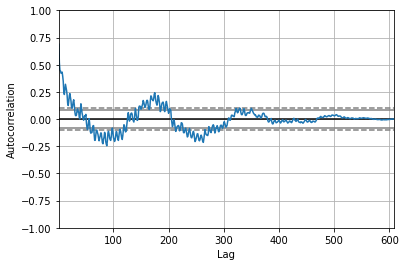

In [0]:
# checking the autocorrelation plot
autocorrelation_plot(join_df)
pyplot.show()

From the autocorrelation plot above we can see that there is a positive correlation with the first ~20 lags.

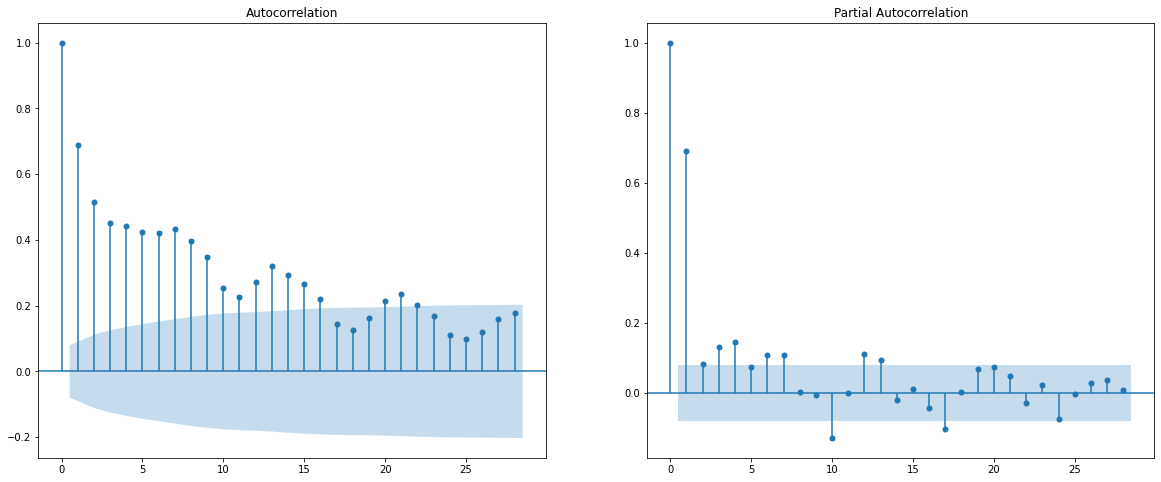

In [0]:
# let's also check the ACF and PACF plots
# resource: https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

f = plt.figure(figsize=(20,8))
ax1 = f.add_subplot(121)
plot_acf(series, ax=ax1)

ax2 = f.add_subplot(122)
plot_pacf(series, ax=ax2)
plt.show()

However, one can see from the ACF plot above that the data is highly correlated with the observations around it which is not ideal for ARIMA so let's use some differencing.

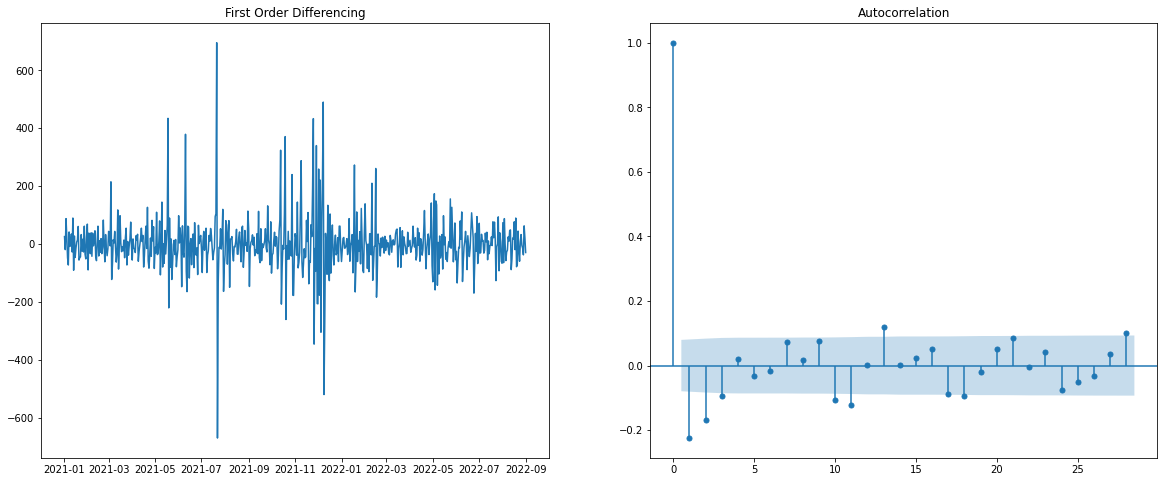

In [0]:
# resource: https://www.projectpro.io/article/how-to-build-arima-model-in-python/544
f = plt.figure(figsize=(20,8))
ax1 = f.add_subplot(121)
ax1.set_title("First Order Differencing")
ax1.plot(series.diff())

ax2 = f.add_subplot(122)
plot_acf(series.diff().dropna(), ax=ax2)
plt.show()

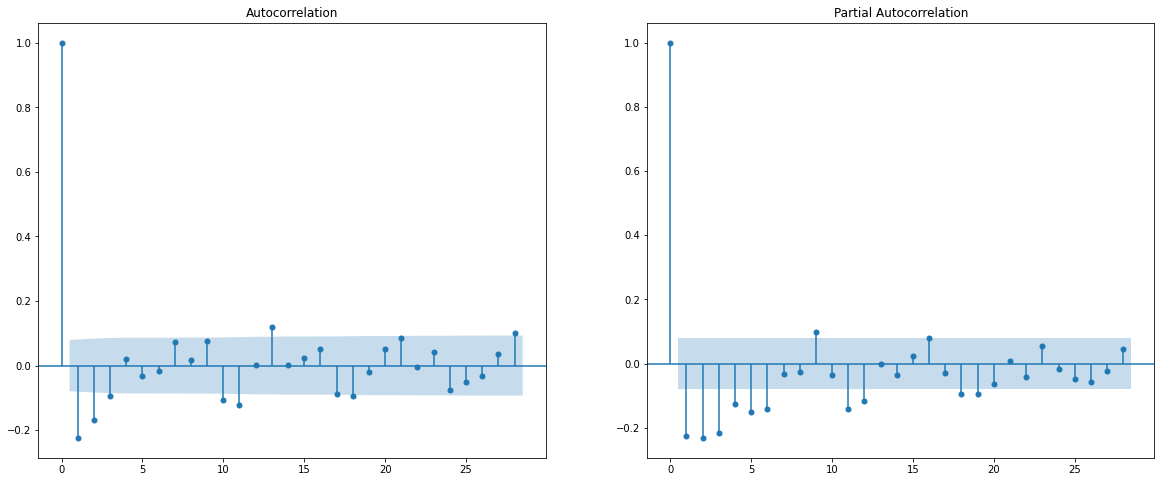

In [0]:
# plotting both plots for first order differencing

series_diff = series.diff()

f = plt.figure(figsize=(20,8))
ax1 = f.add_subplot(121)
plot_acf(series_diff.dropna(), ax=ax1)

ax2 = f.add_subplot(122)
plot_pacf(series_diff.dropna(), ax=ax2)
plt.show()

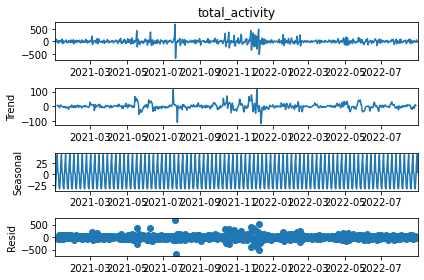

In [0]:
# now let's check for seasonality
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_data = seasonal_decompose(series_diff.dropna(), model="additive")
decompose_data.plot()
pyplot.show()

There is clear seasonality as seen in the plot above so an SARIMA model will most likely be the best fit model.

In [0]:
# inferring the index
# resource: https://stackoverflow.com/questions/49547245/valuewarning-no-frequency-information-was-provided-so-inferred-frequency-ms-wi
series.index = pd.DatetimeIndex(series.index.values,
                               freq=series.index.inferred_freq)

In [0]:
# let's use grid search to find the optimal SARIMA model
# grid search function adapted from: https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-two/
import itertools
import statsmodels.api as sm

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    scores = {}
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                mystr = str(param+param_seasonal)
                scores[mystr] = [results.aic, results.bic]
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))
    return param_mini, param_seasonal_mini, mini, scores

In [0]:
# the lag plot above suggests a correlation with the 20 previous lags so we will use a seasonal period of 20
# selecting best model based on AIC score
param1, param2, AIC, for_table = sarima_grid_search(series,20)

The set of parameters with the minimum AIC is: SARIMA(1, 1, 1)x(0, 1, 1, 20) - AIC:6715.416410058406


In [0]:
# getting info for table
for_table_csv = pd.DataFrame(for_table.items(), columns=['Order', 'AIC_BIC'])
for_table_csv[['AIC','BIC']] = pd.DataFrame(for_table_csv.AIC_BIC.tolist(), index= for_table_csv.index)
for_table_csv = for_table_csv.drop("AIC_BIC", axis = 1)
for_table_csv.head()

,Order,AIC,BIC
0,"(0, 0, 0, 0, 0, 0, 20)",8283.212589,8287.621118
1,"(0, 0, 0, 0, 0, 1, 20)",7758.831593,7767.581643
2,"(0, 0, 0, 0, 1, 0, 20)",7572.019715,7576.394740
3,"(0, 0, 0, 0, 1, 1, 20)",7126.639288,7135.320006
4,"(0, 0, 0, 1, 0, 0, 20)",7504.552151,7513.305605


In [0]:
# saving as csv
import os
fpath = os.path.join("/Workspace/Repos/cag199@georgetown.edu/fall-2022-reddit-big-data-project-project-group-16/data/csv/ML", "Q4_GlossierSARIMA_scores.csv")
for_table_csv.to_csv(fpath)
for_table_csv.head(10)

,Order,AIC,BIC
0,"(0, 0, 0, 0, 0, 0, 20)",8283.212589,8287.621118
1,"(0, 0, 0, 0, 0, 1, 20)",7758.831593,7767.581643
2,"(0, 0, 0, 0, 1, 0, 20)",7572.019715,7576.394740
3,"(0, 0, 0, 0, 1, 1, 20)",7126.639288,7135.320006
4,"(0, 0, 0, 1, 0, 0, 20)",7504.552151,7513.305605
5,"(0, 0, 0, 1, 0, 1, 20)",7370.720951,7383.846025
6,"(0, 0, 0, 1, 1, 0, 20)",7239.094278,7247.778521
7,"(0, 0, 0, 1, 1, 1, 20)",7108.085803,7121.106881
8,"(0, 0, 1, 0, 0, 0, 20)",7790.051701,7798.865461
9,"(0, 0, 1, 0, 0, 1, 20)",7396.164916,7409.284875


In [0]:
# now let's fit the optimal model
model = sm.tsa.statespace.SARIMAX(series, order=param1, seasonal_order=param2, enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                     total_activity   No. Observations:                  608
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 20)   Log Likelihood               -3353.708
Date:                            Mon, 05 Dec 2022   AIC                           6715.416
Time:                                    02:04:33   BIC                           6732.764
Sample:                                01-01-2021   HQIC                          6722.187
                                     - 08-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4534      0.036     12.431      0.000       0.382       0.525
ma.L1         -0.8764      0.025   

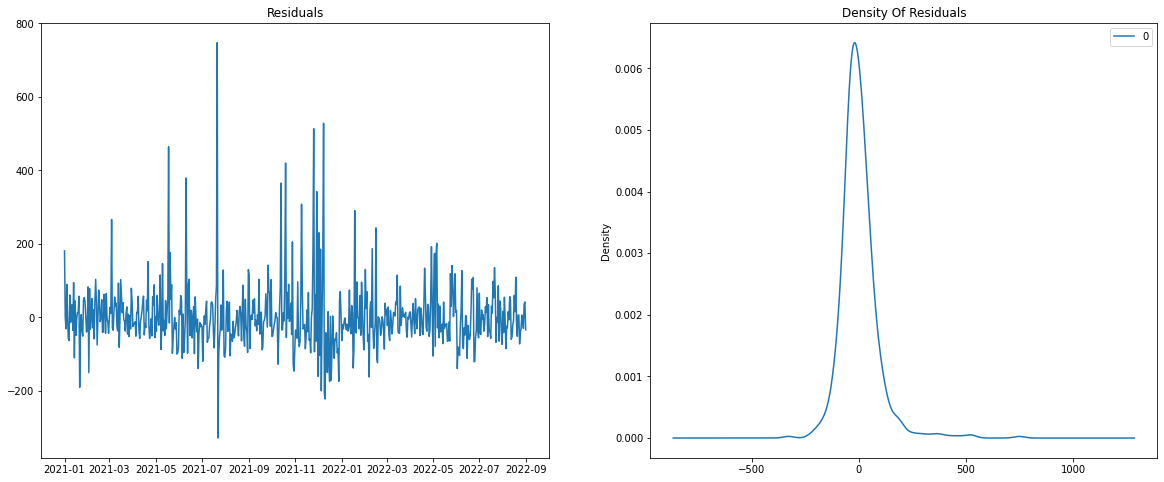

In [0]:
# getting plots of residuals
f = plt.figure(figsize=(20,8))
ax1 = f.add_subplot(121)
ax1.set_title("Residuals")
residuals = pd.DataFrame(model_fit.resid)
ax1.plot(residuals)

ax2 = f.add_subplot(122)
ax2.set_title("Density Of Residuals")
residuals.plot(kind='kde', ax=ax2)
plt.show()

In [0]:
# summary stats of residuals
print(residuals.describe())

                0
count  608.000000
mean     1.425265
std     89.606747
min   -328.292791
25%    -44.938987
50%     -7.651102
75%     33.865375
max    747.380515


The plots of the residuals above show that the residuals are centered around ~0 and suggest that this is be a best fit model for the data.

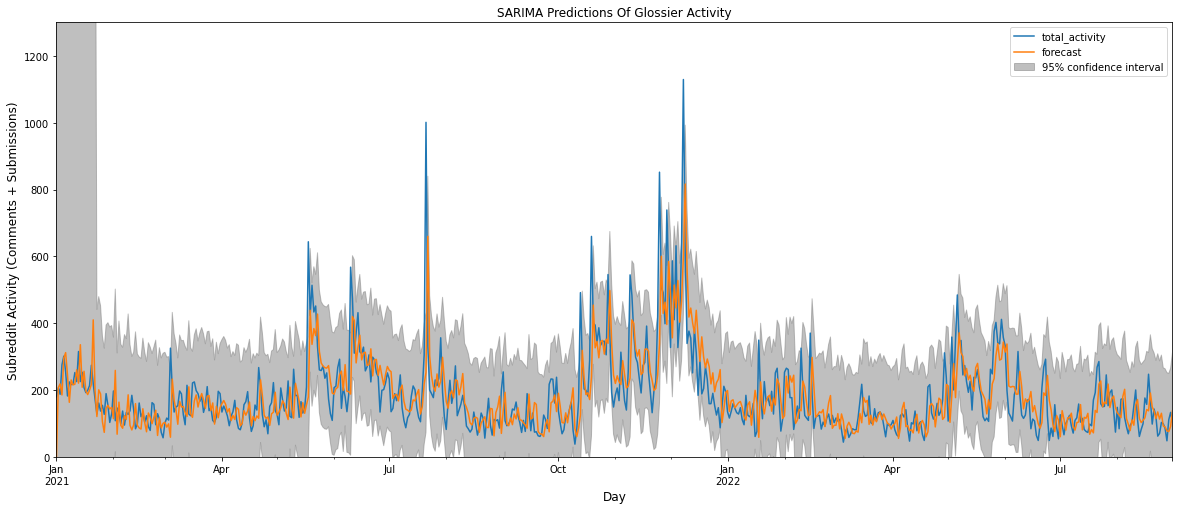

In [0]:
# now let's take a look at the predictions
# resource: https://stackoverflow.com/questions/73112516/arimaresults-object-has-no-attribute-plot-predict-error
from statsmodels.graphics.tsaplots import plot_predict

fig, ax = plt.subplots(figsize=(20,8))
ax = series.plot(ax=ax)
ax.set_title("SARIMA Predictions Of Glossier Activity")
plt.xlabel('Day', fontsize=12)
plt.ylabel('Subreddit Activity (Comments + Submissions)', fontsize=12)
plot_predict(model_fit, ax=ax)
plt.ylim(0,1300)
plt.show()

One can see that the model's forecasts are quite accurate.

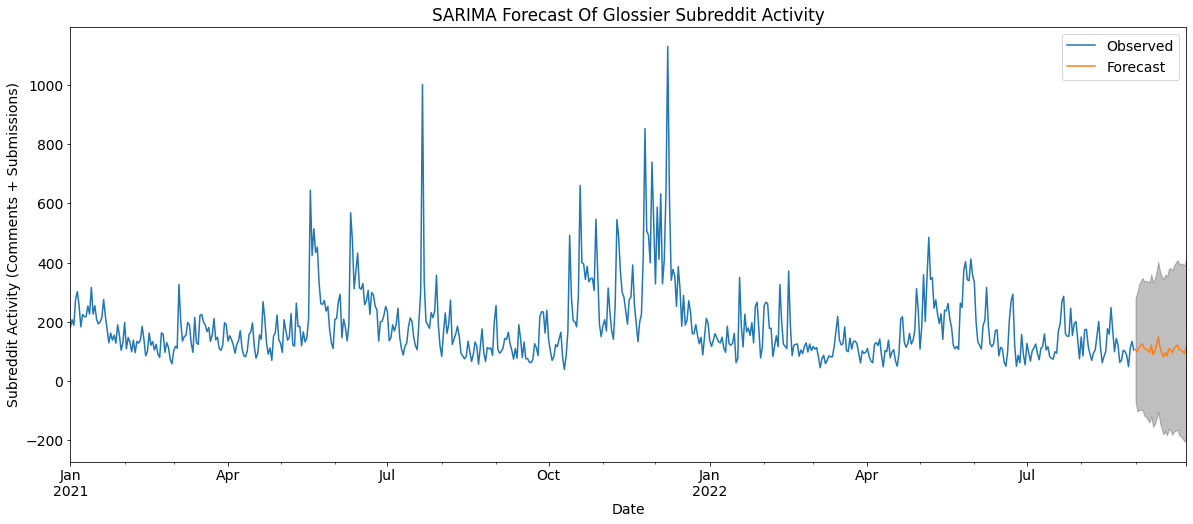

In [0]:
# now let's obtain the forecasts
# resource: https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-two/

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

# let's predict 30 days into the future
pred_uc = model_fit.get_forecast(steps=30)

pred_ci = pred_uc.conf_int()

ax = series.plot(label='Observed', figsize=(20, 8))

pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Subreddit Activity (Comments + Submissions)')
ax.set_title("SARIMA Forecast Of Glossier Subreddit Activity")

plt.legend()
plt.savefig('/Workspace/Repos/cag199@georgetown.edu/fall-2022-reddit-big-data-project-project-group-16/data/plots/ML/Q4_viz1.png')
plt.show()



In [0]:
# Produce the forcasted tables 
# resource: https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-two/

pm = pred_uc.predicted_mean.reset_index()
pm.columns = ['Date','Predicted_Mean']
pci = pred_ci.reset_index()
pci.columns = ['Date','Lower Bound','Upper Bound']
final_table = pm.join(pci.set_index('Date'), on='Date')

## save the csv file in the csv dir
import os
fpath = os.path.join("/Workspace/Repos/cag199@georgetown.edu/fall-2022-reddit-big-data-project-project-group-16/data/csv/ML", "Q4_GlossierSARIMA.csv")
final_table.to_csv(fpath)
final_table.head(10)

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2022-09-01,107.184367,-66.681443,281.050177
1,2022-09-02,98.671930,-102.063792,299.407652
2,2022-09-03,113.226465,-98.390392,324.843322
3,2022-09-04,119.789810,-98.090268,337.669888
4,2022-09-05,125.683311,-96.797403,348.164025
5,2022-09-06,110.041497,-116.350793,336.433788
6,2022-09-07,108.880426,-121.104701,338.865552
7,2022-09-08,103.532364,-129.880390,336.945118
8,2022-09-09,96.642524,-140.099667,333.384714
9,2022-09-10,121.138957,-118.864880,361.142795


In [0]:
# save model
model_fit.save('SARIMA_Glossier_model.pkl')

Ulta Activity

In [0]:
# reading in data
competitor_comments = spark.read.parquet("dbfs:/FileStore/glossier/competitor_comments")
competitor_submissions = spark.read.parquet("dbfs:/FileStore/glossier/competitor_submissions")

In [0]:
# cleaning and grouping in the same way as the Glossier data for comparison
## Remove all uneccessary columns from the data frame 
cols = ("author_cakeday","author_flair_css_class","author_flair_text","permalink","stickied","gilded","distinguished","can_gild","retrieved_on","edited")
competitor_comments = competitor_comments.drop(*cols)
competitor_comments.show(5)

+----------------+--------------------+----------------+-----------+-------+------------+---------+----------+-----+---------------+------------+
|          author|                body|controversiality|created_utc|     id|is_submitter|  link_id| parent_id|score|      subreddit|subreddit_id|
+----------------+--------------------+----------------+-----------+-------+------------+---------+----------+-----+---------------+------------+
|  flowersfitness|A Sephora employe...|               0| 1650684025|i5u3s5s|       false|t3_u9r16z|t1_i5u166q|    2|        Sephora|    t5_2uols|
|joannadoesmakeup|This is the nices...|               0| 1650684062|i5u3uoc|        true|t3_u91nxv|t1_i5sya0z|    2|MakeupAddiction|    t5_2rww2|
|joannadoesmakeup|        Thank you 😊|               0| 1650684086|i5u3wd2|        true|t3_u9h6my|t1_i5tc3ao|    1|MakeupAddiction|    t5_2rww2|
|    Thatsoaustin|agreed! it was ve...|               0| 1650684092|i5u3wq0|       false|t3_u9b784|t1_i5qxijr|    2|        S

In [0]:
## Convert the columns to appropriate data type 
competitor_comments = competitor_comments.withColumn("created_utc",competitor_comments.created_utc.cast('timestamp'))

In [0]:
## Convert the data frame into a view to run SQL on 
competitor_comments.createOrReplaceTempView("comp_comm_vw")

## Get a count of all the missing values 
missing_comp_comm = spark.sql("select \
                    sum(case when author is null then 1 else 0 end) as author_count, \
                    sum(case when body is null then 1 else 0 end) as body_count, \
                    sum(case when controversiality is null then 1 else 0 end) as controversiality_count, \
                    sum(case when created_utc is null then 1 else 0 end) as created_utc_count, \
                    sum(case when id is null then 1 else 0 end) as id_count, \
                    sum(case when is_submitter is null then 1 else 0 end) as is_submitter_count, \
                    sum(case when link_id is null then 1 else 0 end) as link_id_count, \
                    sum(case when parent_id is null then 1 else 0 end) as parent_id_count, \
                    sum(case when score is null then 1 else 0 end) as score_count, \
                    sum(case when subreddit is null then 1 else 0 end) as subreddit_count, \
                    sum(case when subreddit_id is null then 1 else 0 end) as subreddit_id_count \
                    from comp_comm_vw")

## Show and view the results 
missing_comp_comm.show()


+------------+----------+----------------------+-----------------+--------+------------------+-------------+---------------+-----------+---------------+------------------+
|author_count|body_count|controversiality_count|created_utc_count|id_count|is_submitter_count|link_id_count|parent_id_count|score_count|subreddit_count|subreddit_id_count|
+------------+----------+----------------------+-----------------+--------+------------------+-------------+---------------+-----------+---------------+------------------+
|           0|         0|                     0|                0|       0|                 0|            0|              0|          0|              0|                 0|
+------------+----------+----------------------+-----------------+--------+------------------+-------------+---------------+-----------+---------------+------------------+



In [0]:
## Drop all of the uneccessary columns
cols = ("whitelist_status","url","thumbnail_width","thumbnail_height","thumbnail","third_party_tracking_2","third_party_tracking","third_party_trackers","suggested_sort",
       "secure_media_embed", "retrieved_on", "promoted_url", "parent_whitelist_status", "link_flair_text", "link_flair_css_class", "imp_pixel", "href_url", "gilded", "embed_url", 
       "author_flair_css_class", "author_cakeday","adserver_imp_pixel", "adserver_click_url", "secure_media_embed", "secure_media", "post_hint", "permalink", "original_link", 
       "mobile_ad_url", "embed_type", "domain_override", "domain", "author", "preview", "author_flair_text", "edited", "crosspost_parent_list", "media", "media_embed")
competitor_submissions = competitor_submissions.drop(*cols)
competitor_submissions.columns

Out[55]: ['archived',
 'author_id',
 'brand_safe',
 'contest_mode',
 'created_utc',
 'crosspost_parent',
 'disable_comments',
 'distinguished',
 'hidden',
 'hide_score',
 'id',
 'is_crosspostable',
 'is_reddit_media_domain',
 'is_self',
 'is_video',
 'locked',
 'num_comments',
 'num_crossposts',
 'over_18',
 'pinned',
 'promoted',
 'promoted_by',
 'promoted_display_name',
 'score',
 'selftext',
 'spoiler',
 'stickied',
 'subreddit',
 'subreddit_id',
 'title']

In [0]:
## Convert the data frame into a view to run SQL on 
competitor_submissions.createOrReplaceTempView("comp_sub_vw")

## Part 1: 
## Get a count of all the missing values 
missing_comp_sub1= spark.sql("select sum(case when author_id is null then 1 else 0 end) as author_id, \
                    sum(case when archived is null then 1 else 0 end) as archived, \
                    sum(case when brand_safe is null then 1 else 0 end) as brand_safe, \
                    sum(case when created_utc is null then 1 else 0 end) as created_utc, \
                    sum(case when crosspost_parent is null then 1 else 0 end) as crosspost_parent, \
                    sum(case when disable_comments is null then 1 else 0 end) as disable_comments, \
                    sum(case when distinguished is null then 1 else 0 end) as distinguished, \
                    sum(case when hidden is null then 1 else 0 end) as hidden, \
                    sum(case when hide_score is null then 1 else 0 end) as hide_score, \
                    sum(case when id is null then 1 else 0 end) as id, \
                    sum(case when is_crosspostable is null then 1 else 0 end) as is_crosspostable, \
                    sum(case when is_reddit_media_domain is null then 1 else 0 end) as is_reddit_media_domain, \
                    sum(case when is_self is null then 1 else 0 end) as is_self, \
                    sum(case when is_video is null then 1 else 0 end) as is_video, \
                    sum(case when locked is null then 1 else 0 end) as locked \
                    from comp_sub_vw")

## Show and view the results 
missing_comp_sub1.show()

+---------+--------+----------+-----------+----------------+----------------+-------------+------+----------+---+----------------+----------------------+-------+--------+------+
|author_id|archived|brand_safe|created_utc|crosspost_parent|disable_comments|distinguished|hidden|hide_score| id|is_crosspostable|is_reddit_media_domain|is_self|is_video|locked|
+---------+--------+----------+-----------+----------------+----------------+-------------+------+----------+---+----------------+----------------------+-------+--------+------+
|   108341|       0|    108341|          0|          108105|          108341|       108306|     0|         0|  0|               0|                     0|      0|       0|     0|
+---------+--------+----------+-----------+----------------+----------------+-------------+------+----------+---+----------------+----------------------+-------+--------+------+



In [0]:
## Get a count of all the missing values 
missing_comp_sub2 = spark.sql("select sum(case when num_comments is null then 1 else 0 end) as num_comments,\
                    sum(case when num_crossposts is null then 1 else 0 end) as num_crossposts,\
                    sum(case when over_18 is null then 1 else 0 end) as over_18,\
                    sum(case when pinned is null then 1 else 0 end) as pinned,\
                    sum(case when promoted is null then 1 else 0 end) as promoted,\
                    sum(case when promoted_by is null then 1 else 0 end) as promoted_by,\
                    sum(case when promoted_by is null then 1 else 0 end) as promoted_display_name,\
                    sum(case when score is null then 1 else 0 end) as score,\
                    sum(case when selftext is null then 1 else 0 end) as selftext,\
                    sum(case when spoiler is null then 1 else 0 end) as spoiler,\
                    sum(case when stickied is null then 1 else 0 end) as stickied,\
                    sum(case when subreddit is null then 1 else 0 end) as subreddit,\
                    sum(case when subreddit_id is null then 1 else 0 end) as subreddit_id,\
                    sum(case when title is null then 1 else 0 end) as title\
                    from comp_sub_vw")

## Show and view the results 
missing_comp_sub2.show()

+------------+--------------+-------+------+--------+-----------+---------------------+-----+--------+-------+--------+---------+------------+-----+
|num_comments|num_crossposts|over_18|pinned|promoted|promoted_by|promoted_display_name|score|selftext|spoiler|stickied|subreddit|subreddit_id|title|
+------------+--------------+-------+------+--------+-----------+---------------------+-----+--------+-------+--------+---------+------------+-----+
|           0|             0|      0|     0|  108341|     108341|               108341|    0|       0|      0|       0|        0|           0|    0|
+------------+--------------+-------+------+--------+-----------+---------------------+-----+--------+-------+--------+---------+------------+-----+



In [0]:
## Convert the columns to appropriate data type 
competitor_submissions = competitor_submissions.withColumn("created_utc",competitor_submissions.created_utc.cast('timestamp'))

In [0]:
competitor_submissions.count()

Out[59]: 108341

In [0]:
competitor_comments.count()

Out[60]: 1105784

In [0]:
# getting ulta submissions and grouping by day
from pyspark.sql.functions import col, asc,desc
from pyspark.sql.functions import *

## Filter to the glossier subreddit only 
submissions_by_subreddit = competitor_comments.filter((col("subreddit") == "Ulta"))
## Get the count of records for each day 
submissions_by_subreddit = submissions_by_subreddit.groupBy(to_date("created_utc").alias("dt_day")).agg(count("id").alias("comment_count"))

## Filter to the glossier subreddit only 
submissions_by_subreddit2 = competitor_submissions.filter((col("subreddit") == "Ulta"))
## Get the count of records for each day 
submissions_by_subreddit2 = submissions_by_subreddit2.groupBy(to_date("created_utc").alias("dt")).agg(count("id").alias("submission_count"))

In [0]:
## We are using SQL so need to convert them into views 
submissions_by_subreddit2.createOrReplaceTempView("x_vw")
submissions_by_subreddit.createOrReplaceTempView("y_vw")

# joining
join_df = submissions_by_subreddit2.join(submissions_by_subreddit,submissions_by_subreddit2.dt ==  submissions_by_subreddit.dt_day,"outer")
join_df = join_df.drop("dt")
join_df.show()

+----------------+----------+-------------+
|submission_count|    dt_day|comment_count|
+----------------+----------+-------------+
|              12|2021-01-01|          144|
|               7|2021-01-02|           77|
|              10|2021-01-03|          103|
|              20|2021-01-04|          135|
|              10|2021-01-05|          148|
|              11|2021-01-06|           93|
|              10|2021-01-07|          122|
|               6|2021-01-08|          104|
|               5|2021-01-09|           59|
|              12|2021-01-10|          106|
|              10|2021-01-11|           59|
|              14|2021-01-12|           87|
|              13|2021-01-13|           81|
|               8|2021-01-14|           66|
|              12|2021-01-15|          147|
|               9|2021-01-16|           93|
|              10|2021-01-17|           80|
|               7|2021-01-18|           87|
|               8|2021-01-19|           80|
|               9|2021-01-20|   

In [0]:
# getting total activity
join_df = join_df.withColumn('total_activity', join_df.submission_count + join_df.comment_count)
join_df = join_df.drop("submission_count","comment_count")
join_df = join_df.toPandas()
join_df.head(10)

,dt_day,total_activity
0,2021-01-01,156.0
1,2021-01-02,84.0
2,2021-01-03,113.0
3,2021-01-04,155.0
4,2021-01-05,158.0
5,2021-01-06,104.0
6,2021-01-07,132.0
7,2021-01-08,110.0
8,2021-01-09,64.0
9,2021-01-10,118.0


In [0]:
# saving this dataset
fpath = os.path.join("/Workspace/Repos/cag199@georgetown.edu/fall-2022-reddit-big-data-project-project-group-16/data/csv/ML", "Ulta_Activity.csv")
join_df.to_csv(fpath)

In [0]:
# looking for nulls
bool_series = pd.isnull(join_df["total_activity"])
   
# filtering data
join_df[bool_series]

,dt_day,total_activity
42,2021-02-12,NaN


In [0]:
# let's imput this as the average of the days near it
row_index_list = [40, 41, 43, 44]

imp_mean = join_df["total_activity"].iloc[row_index_list].mean(axis=0)
imp_mean

Out[66]: 118.0

In [0]:
# imputing nulls as zeros
join_df["total_activity"] = join_df["total_activity"].fillna(imp_mean)
join_df["total_activity"].isnull().sum()

Out[67]: 0

In [0]:
# datatype parsing
join_df["dt_day"] = pd.to_datetime(join_df["dt_day"], format="%Y-%m-%d")
join_df = join_df.set_index('dt_day')
join_df.head()

,total_activity
dt_day,
2021-01-01,156.0
2021-01-02,84.0
2021-01-03,113.0
2021-01-04,155.0
2021-01-05,158.0


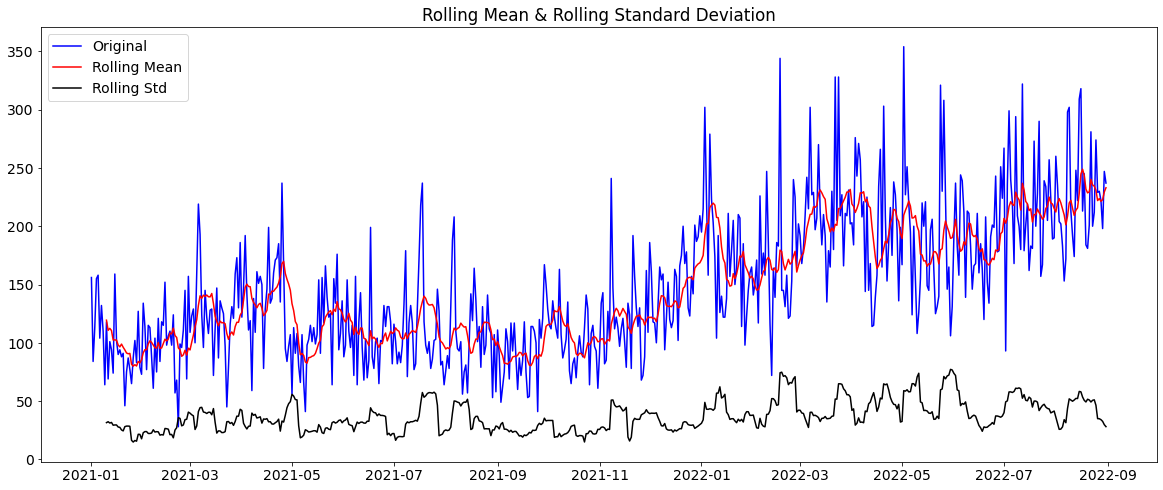

In [0]:
# viewing the rolling mean and rolling std
# resource: https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7

rolling_mean = join_df.rolling(window = 10).mean()
rolling_std = join_df.rolling(window = 10).std()

plt.figure(figsize=(20,8))
plt.plot(join_df, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

Unlike in the Glossier activity data, we see a slight upward trend over time in the Ulta subreddit activity data. The data does not look stationary but let's use an ADF test to be sure.

In [0]:
result = adfuller(join_df['total_activity'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))

ADF Statistic: -1.6239590953312582
p-value: 0.47065431326991536


The p value is greater than 0.05 so we know that the data is not stationary. We must induce stationarity.

In [0]:
# converting to series
series = join_df.squeeze()
series.head()

Out[71]: dt_day
2021-01-01    156.0
2021-01-02     84.0
2021-01-03    113.0
2021-01-04    155.0
2021-01-05    158.0
Name: total_activity, dtype: float64

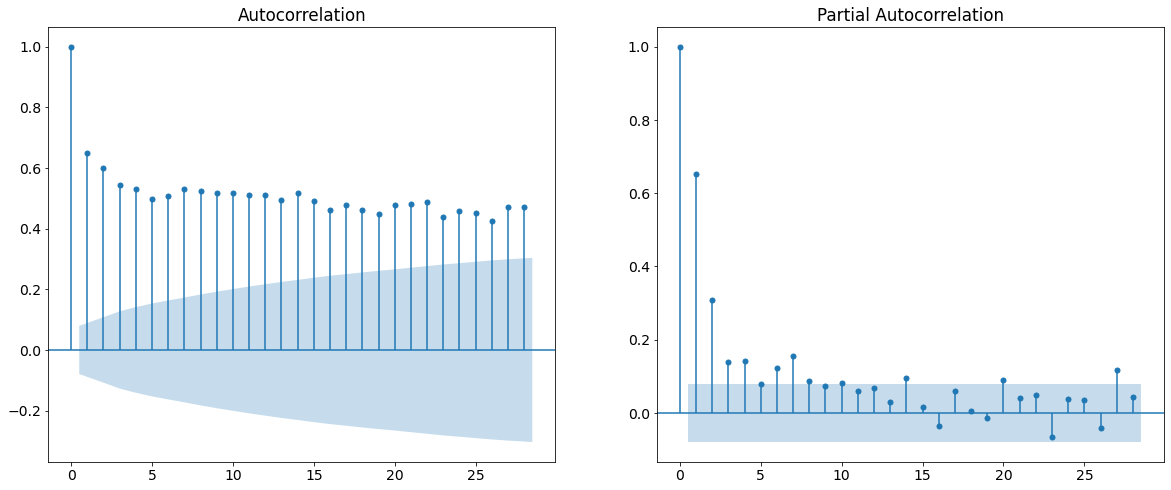

In [0]:
f = plt.figure(figsize=(20,8))
ax1 = f.add_subplot(121)
plot_acf(series, ax=ax1)

ax2 = f.add_subplot(122)
plot_pacf(series, ax=ax2)
plt.show()

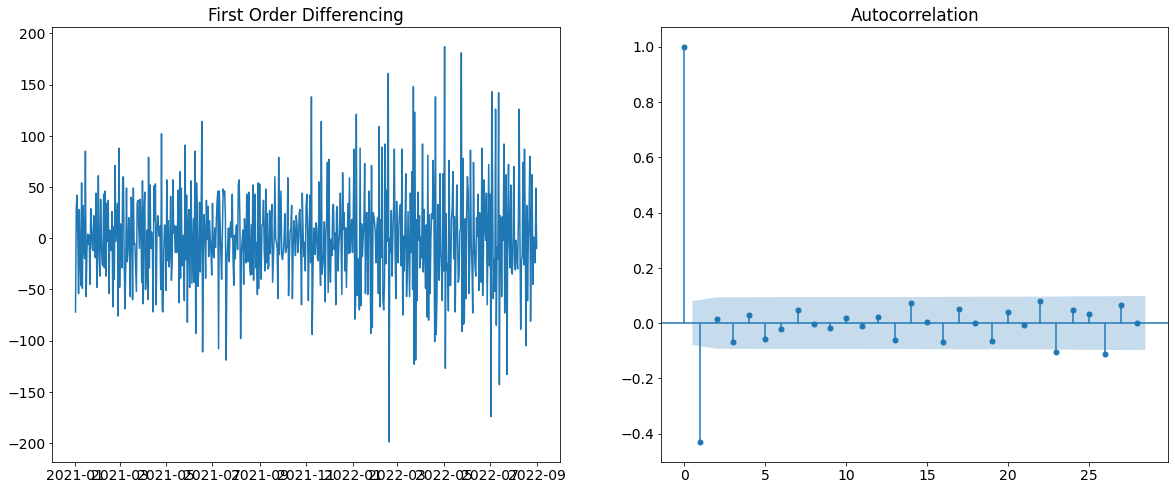

In [0]:
# inducing stationarity with differencing 
# resource: https://www.projectpro.io/article/how-to-build-arima-model-in-python/544
f = plt.figure(figsize=(20,8))
ax1 = f.add_subplot(121)
ax1.set_title("First Order Differencing")
ax1.plot(series.diff())

ax2 = f.add_subplot(122)
plot_acf(series.diff().dropna(), ax=ax2)
plt.show()

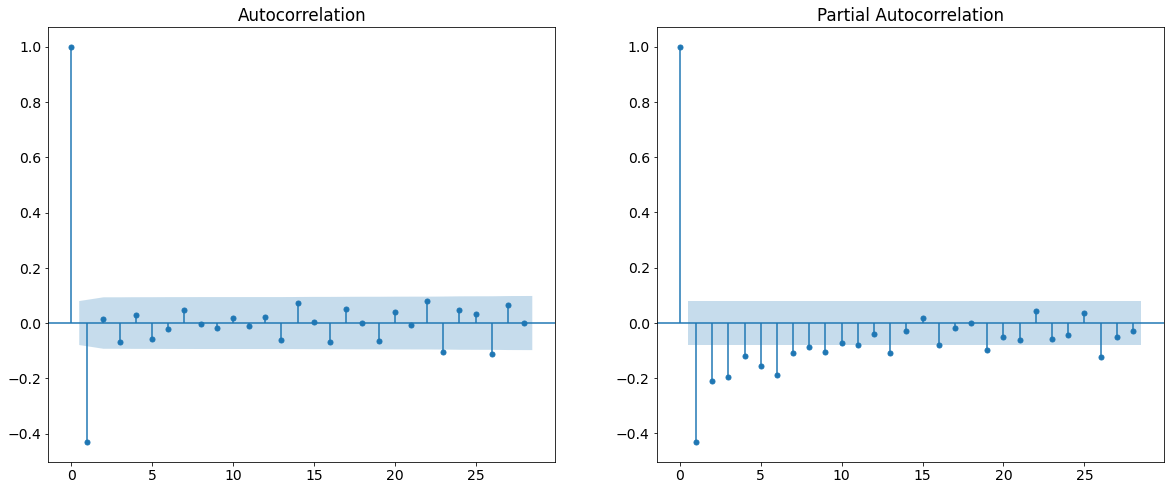

In [0]:
# plotting both plots for first order differencing

series_diff = series.diff()

f = plt.figure(figsize=(20,8))
ax1 = f.add_subplot(121)
plot_acf(series_diff.dropna(), ax=ax1)

ax2 = f.add_subplot(122)
plot_pacf(series_diff.dropna(), ax=ax2)
plt.show()

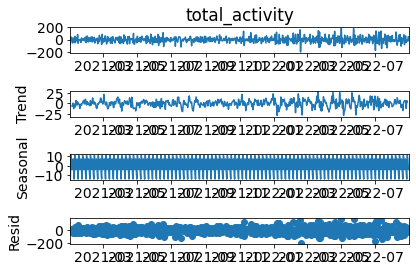

In [0]:
decompose_data = seasonal_decompose(series_diff.dropna(), model="additive")
decompose_data.plot()
pyplot.show()

Again, we see that there is significant seasonality in this data. Let's fit it using a SARIMA model.

In [0]:
# inferring the index
# resource: https://stackoverflow.com/questions/49547245/valuewarning-no-frequency-information-was-provided-so-inferred-frequency-ms-wi
series.index = pd.DatetimeIndex(series.index.values,
                               freq=series.index.inferred_freq)

In [0]:
# similar to glossier we will use a seasonal period of 20
# selecting best model based on AIC score
param1, param2, AIC, for_table2 = sarima_grid_search(series, 20)

The set of parameters with the minimum AIC is: SARIMA(1, 1, 1)x(0, 1, 1, 20) - AIC:5852.967999132163


In [0]:
# getting info for table
for_table2_csv = pd.DataFrame(for_table2.items(), columns=['Order', 'AIC_BIC'])
for_table2_csv[['AIC','BIC']] = pd.DataFrame(for_table2_csv.AIC_BIC.tolist(), index= for_table2_csv.index)
for_table2_csv = for_table2_csv.drop("AIC_BIC", axis = 1)
for_table2_csv.head()

,Order,AIC,BIC
0,"(0, 0, 0, 0, 0, 0, 20)",7878.401735,7882.810264
1,"(0, 0, 0, 0, 0, 1, 20)",7186.598988,7195.349038
2,"(0, 0, 0, 0, 1, 0, 20)",6445.793391,6450.168416
3,"(0, 0, 0, 0, 1, 1, 20)",6042.844069,6051.524788
4,"(0, 0, 0, 1, 0, 0, 20)",6454.247190,6463.000644


In [0]:
## save the csv file in the csv dir
import os
fpath = os.path.join("/Workspace/Repos/cag199@georgetown.edu/fall-2022-reddit-big-data-project-project-group-16/data/csv/ML", "Q4_UltaSARIMA_scores.csv")
for_table2_csv.to_csv(fpath)
for_table2_csv.head(10)

,Order,AIC,BIC
0,"(0, 0, 0, 0, 0, 0, 20)",7878.401735,7882.810264
1,"(0, 0, 0, 0, 0, 1, 20)",7186.598988,7195.349038
2,"(0, 0, 0, 0, 1, 0, 20)",6445.793391,6450.168416
3,"(0, 0, 0, 0, 1, 1, 20)",6042.844069,6051.524788
4,"(0, 0, 0, 1, 0, 0, 20)",6454.247190,6463.000644
5,"(0, 0, 0, 1, 0, 1, 20)",6217.895018,6231.020092
6,"(0, 0, 0, 1, 1, 0, 20)",6119.665820,6128.350063
7,"(0, 0, 0, 1, 1, 1, 20)",6044.831574,6057.852652
8,"(0, 0, 1, 0, 0, 0, 20)",7346.123454,7354.937214
9,"(0, 0, 1, 0, 0, 1, 20)",6823.346709,6836.466668


In [0]:
# now let's fit the optimal model
model = sm.tsa.statespace.SARIMAX(series, order=param1, seasonal_order=param2, enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                     total_activity   No. Observations:                  608
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 20)   Log Likelihood               -2922.484
Date:                            Mon, 05 Dec 2022   AIC                           5852.968
Time:                                    02:10:45   BIC                           5870.315
Sample:                                01-01-2021   HQIC                          5859.739
                                     - 08-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2471      0.045      5.468      0.000       0.159       0.336
ma.L1         -0.9409      0.015   

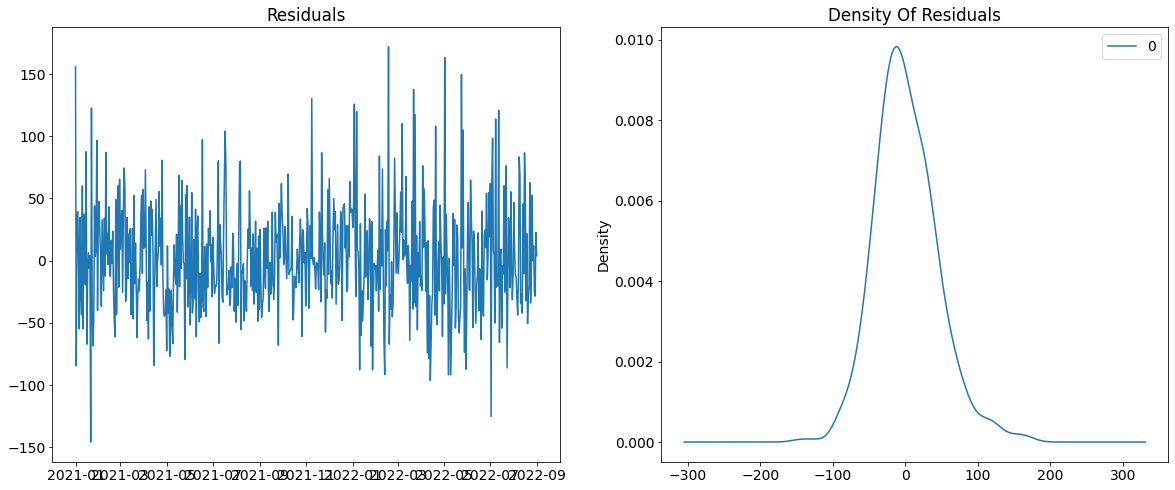

In [0]:
# getting plots of residuals
f = plt.figure(figsize=(20,8))
ax1 = f.add_subplot(121)
ax1.set_title("Residuals")
residuals = pd.DataFrame(model_fit.resid)
ax1.plot(residuals)

ax2 = f.add_subplot(122)
ax2.set_title("Density Of Residuals")
residuals.plot(kind='kde', ax=ax2)
plt.show()

In [0]:
# summary stats of residuals
print(residuals.describe())

                0
count  608.000000
mean     1.389067
std     43.513845
min   -146.066756
25%    -26.128918
50%     -3.284787
75%     26.042520
max    172.100050


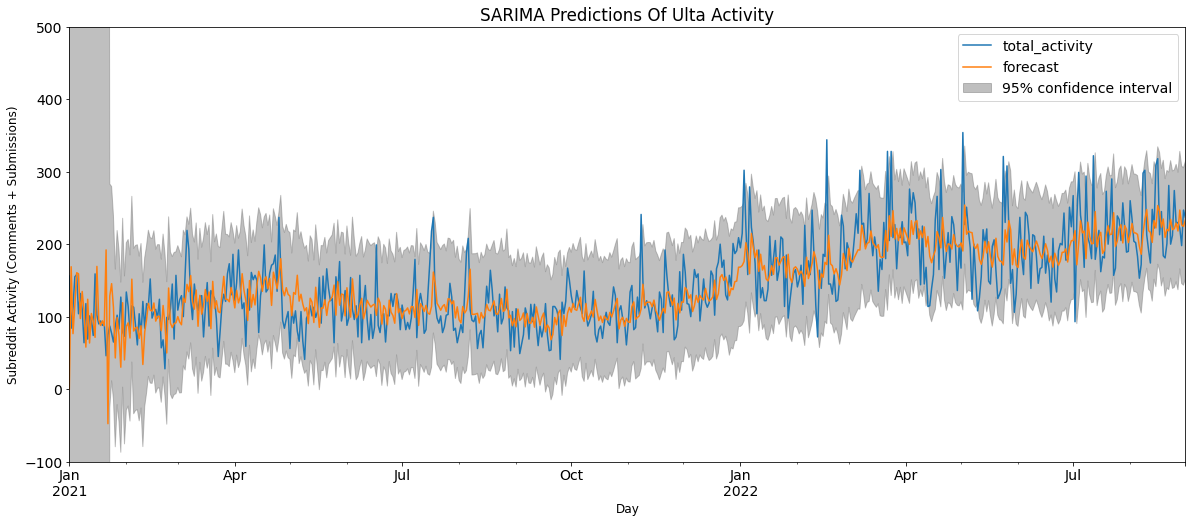

In [0]:
# now let's take a look at the predictions
# resource: https://stackoverflow.com/questions/73112516/arimaresults-object-has-no-attribute-plot-predict-error

fig, ax = plt.subplots(figsize=(20,8))
ax = series.plot(ax=ax)
ax.set_title("SARIMA Predictions Of Ulta Activity")
plt.xlabel('Day', fontsize=12)
plt.ylabel('Subreddit Activity (Comments + Submissions)', fontsize=12)
plot_predict(model_fit, ax=ax)
plt.ylim(-100, 500)
plt.show()

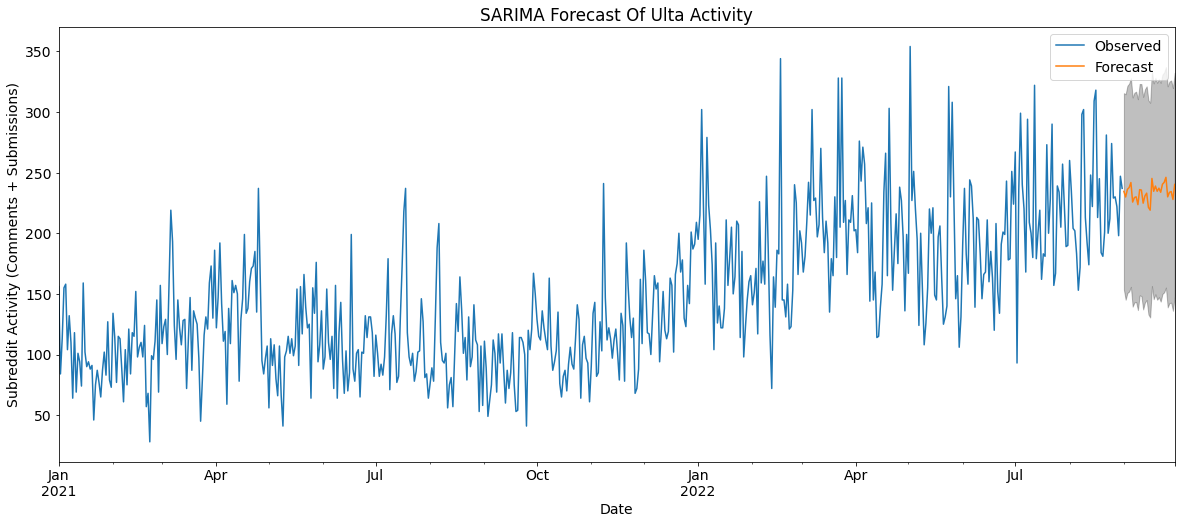

In [0]:
# now let's obtain the forecasts
# resource: https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-two/

plt.rcParams.update({'font.size': 14})

# let's predict 30 days into the future
pred_uc = model_fit.get_forecast(steps=30)

pred_ci = pred_uc.conf_int()

ax = series.plot(label='Observed', figsize=(20, 8))

pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Subreddit Activity (Comments + Submissions)')
ax.set_title("SARIMA Forecast Of Ulta Activity")

plt.legend()
plt.savefig('/Workspace/Repos/cag199@georgetown.edu/fall-2022-reddit-big-data-project-project-group-16/data/plots/ML/Q4_viz2.png')
plt.show()

In [0]:
# Produce the forcasted tables 
# resource: https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-two/

pm = pred_uc.predicted_mean.reset_index()
pm.columns = ['Date','Predicted_Mean']
pci = pred_ci.reset_index()
pci.columns = ['Date','Lower Bound','Upper Bound']
final_table = pm.join(pci.set_index('Date'), on='Date')

## save the csv file in the csv dir
import os
fpath = os.path.join("/Workspace/Repos/cag199@georgetown.edu/fall-2022-reddit-big-data-project-project-group-16/data/csv/ML", "Q4_UltaSARIMA.csv")
final_table.to_csv(fpath)
final_table.head(10)

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2022-09-01,234.514963,153.510460,315.519467
1,2022-09-02,229.892360,145.172382,314.612337
2,2022-09-03,236.173323,150.752036,321.594610
3,2022-09-04,237.694653,151.945805,323.443501
4,2022-09-05,241.808066,155.802651,327.813482
5,2022-09-06,225.704152,139.458843,311.949462
6,2022-09-07,229.435815,142.955120,315.916511
7,2022-09-08,230.035431,143.320931,316.749931
8,2022-09-09,223.569242,136.621798,310.516686
9,2022-09-10,235.935136,148.755428,323.114844


In [0]:
# save model
model_fit.save('SARIMA_Ulta_model.pkl')